# Ice Front T/S Scaling with melt

Gustavo Marques

We expect there to be some sort of quadratic relationship between T and melt, based on Holland et al. (2008) and the ice sheet quadratic scaling parameterisation.

In the following plots, we compare the model against a linear or quadratic fit using RMSE as a metric. The smaller the RMSE, the better the fit. Via variable z_value, we can choose the depth below which the model data is extracted. 

In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cftime
from scipy.optimize import curve_fit

from netCDF4 import Dataset
import os.path
import matplotlib.colors as colors

In [2]:
# choose the z value below which temp and salt are extracted.
z_value = -400. # examples 0, -350, -400, -500
# set this to true to save the figures
savefig = False

if os.path.isdir('/g/data/x77/cy8964/isomip-plus/'):
    ## folder where the isomip-plus github repo is located
    baserepo = '/g/data/x77/cy8964/isomip-plus/'
    ## folder where you downloaded the zipped Google Drive data
    basedrive = '/g/data/x77/cy8964/ISOMIP+Data-new/'
else:
  baserepo = '/glade/work/gmarques/Projects/isomip-plus/'
  basedrive = '/glade/derecho/scratch/gmarques/ISOMIP+Data/'

# load the data from the text files, which point to the right location of the file in the drive structure
Ocean0_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean0-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean1_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean1-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean2_COM = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean2-COM.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean0_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean0-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean1_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean1-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)
Ocean2_TYP = np.loadtxt(baserepo+'notebooks/file-pointers/Ocean2-TYP.txt', dtype = 'str', delimiter = ',',usecols = 0)


In [3]:
np.array([1,2,3,4,5])**2

array([ 1,  4,  9, 16, 25])

In [4]:
# Linear regression
def linear_func(t, a, b):
    return a * t + b

# Quadratic regression
def quadratic_func(t, d, e, f):
    return d * t**2 + e * t + f

# Calculate the Root Mean Squared Error (RMSE) between true and predicted values
def rmse(y_true, y_pred):
    """
    Parameters:
        y_true (array-like): True target values.
        y_pred (array-like): Predicted target values.

    Returns:
        float: Root Mean Squared Error (RMSE).
    """
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred)) ** 2))
    
def best_fit(t,m, print=False):
    
    # Fit linear model
    popt_linear, _ = curve_fit(linear_func, t, m)
    # Fit quadratic model
    popt_quadratic, _ = curve_fit(quadratic_func, t, m)
    # Calculate fitted values
    m_linear_fit = linear_func(t, *popt_linear)
    m_quadratic_fit = quadratic_func(t, *popt_quadratic)
    
    # RMSE
    rmse_linear = rmse(m, m_linear_fit)
    rmse_quadratic = rmse(m, m_quadratic_fit)
    
    # Compare RMSE values
    if print:
      print("RMSE for linear model:", rmse_linear)
      print("RMSE for quadratic model:", rmse_quadratic)
        
    if rmse_quadratic <= rmse_linear:
        y = m_quadratic_fit
        fnc = 'quadratic'
        r2 = rmse_quadratic
        p = popt_quadratic
    else:
        y = m_linear_fit
        fnc = 'linear'
        r2 = rmse_linear
        p = popt_linear
    

    return y, fnc, r2,p

In [60]:
sPerYr = 365.*24.*60.*60.
marker = 'o'
mark_size = 5
fs = 13
modelcolours=['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c',
              '#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']

### Melt vs. temperatureYZ

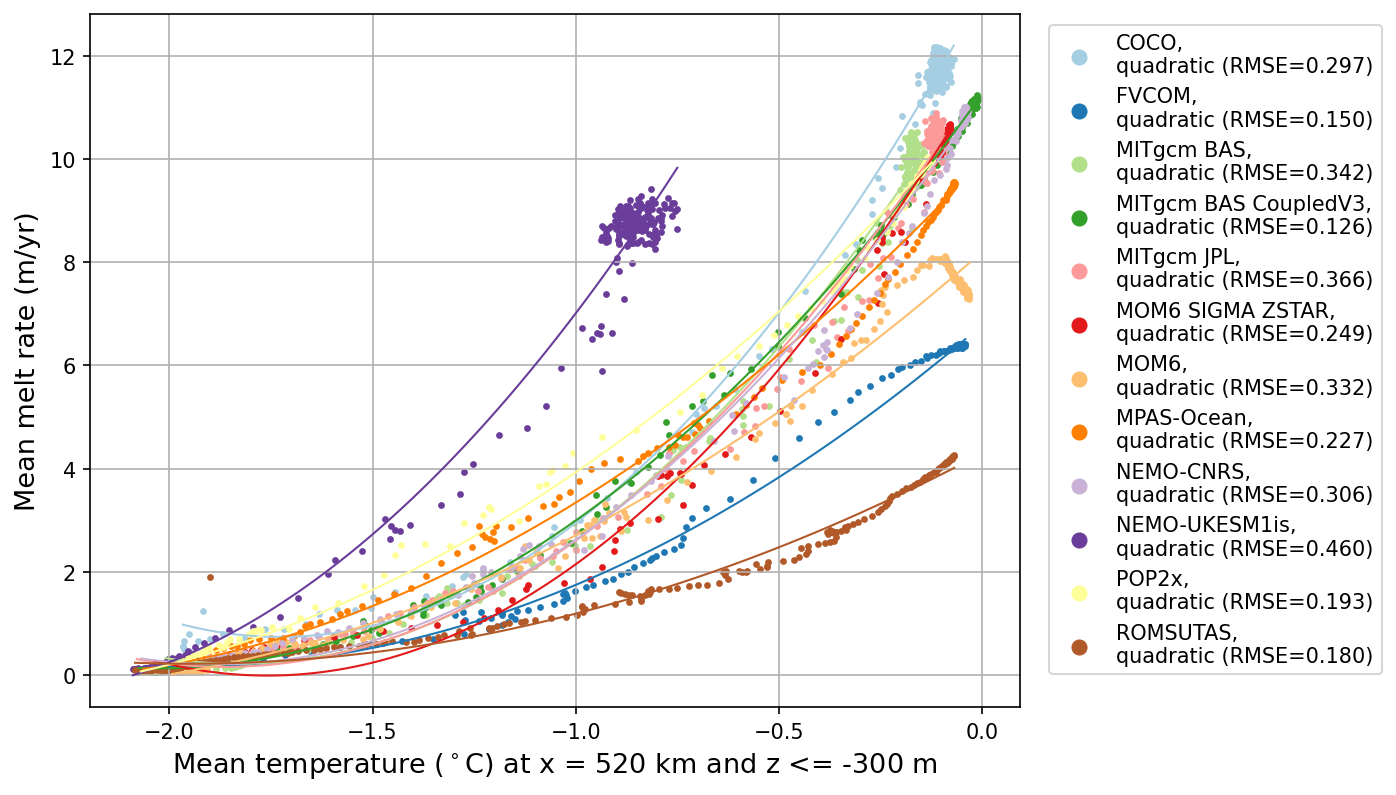

In [61]:
expt = Ocean1_COM
labels = []
for fileIndex in range(len(expt)):
    fileName = expt[fileIndex]
    baseName = os.path.basename(basedrive +fileName)
    modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
    labels.append(modelName)

length = len(expt)
fig = plt.figure(figsize=(8,6),facecolor='w',dpi = 150)

for i in np.arange(length):
    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    # set coords
    data = data.set_coords("x")
    data = data.set_coords("y")
    data = data.set_coords("z")
    # get indices for z<= z_value m
    k_indices = np.where(data.z <= z_value)[0]
    
    mr = data.meltRate
    t = data.temperatureYZ
    mr = mr.where(mr < 1e10).mean(['nx','ny'])*sPerYr
    t = t.where(t < 1e10).isel(nz=k_indices).mean(['ny','nz'])
    #print('model = {}, len(t) = {}, len(mr) = {}'.format(labels[i],len(t), len(mr)))
    ind = np.argsort(t.values)
    t = t.values[ind]
    mr = mr.values[ind]
    y, fnc, r2,p = best_fit(t,mr)   
    if fnc == "quadratic":
        xs = np.linspace(min(t),max(t),100)
        ys = p[0]*xs**2+p[1]*xs+p[2]
    elif fnc == "linear":
        xs = np.linspace(min(t),max(t),100)
        ys = p[0]*xs+p[1]
    label = labels[i] +',\n'+ str(r'{} (RMSE={:.3f})'.format(fnc,r2))
    plt.scatter(t,mr,label = label, s = mark_size, color=modelcolours[i])
    #plt.plot(t,y,'-', color=modelcolours[i], lw=1.)
    plt.plot(xs,ys,'-', color=modelcolours[i], lw=1.)

plt.xlabel('Mean temperature ($^\circ$C) at x = 520 km and z <= {} m'.format(z_value), fontsize=fs)
plt.ylabel('Mean melt rate (m/yr)', fontsize=fs)
plt.gca().legend(ncol=1, loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=10, markerscale = 3)
plt.grid()
if savefig:
    plt.savefig('melt_vs_temp_x520.png', dpi=300, bbox_inches='tight')

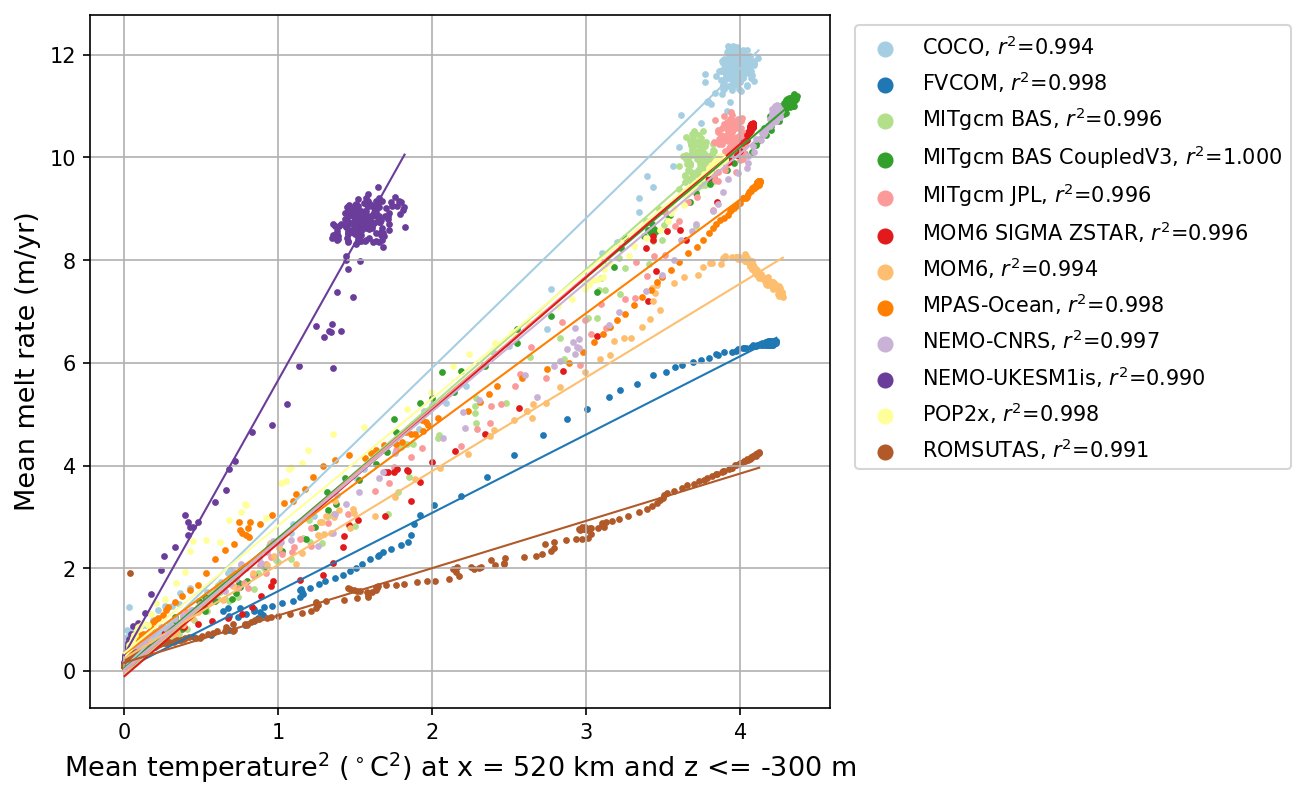

In [62]:
# Linearise the plot

fig = plt.figure(figsize=(14,6),facecolor='w',dpi = 150)

expt = Ocean1_COM
labels = []
for fileIndex in range(len(expt)):
    fileName = expt[fileIndex]
    baseName = os.path.basename(basedrive +fileName)
    modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
    labels.append(modelName)

length = len(expt)
ax = plt.subplot(1,2,1)
for i in np.arange(length):
    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    # set coords
    data = data.set_coords("x")
    data = data.set_coords("y")
    data = data.set_coords("z")
    # get indices for z<= z_value m
    k_indices = np.where(data.z <= z_value)[0]
    
    mr = data.meltRate
    t = data.temperatureYZ
    mr = mr.where(mr < 1e10).mean(['nx','ny'])*sPerYr
    t = t.where(t < 1e10).isel(nz=k_indices).mean(['ny','nz'])
    #print('model = {}, len(t) = {}, len(mr) = {}'.format(labels[i],len(t), len(mr)))
    #ind = np.argsort(t.values)
    #t = t.values[ind]
    #mr = mr.values[ind]
    slope, intercept = np.polyfit((t+2.1)**2, mr, 1)
    correlation_coefficient = np.corrcoef((t+2.1)**2, mr)[0, 1]
    t2s = np.linspace(min((t+2.1)**2),max((t+2.1)**2))
    ys = t2s*slope+intercept
    # y, fnc, r2,p = best_fit(t,mr)   
    # if fnc == "quadratic":
    #     xs = np.linspace(min(t),max(t),100)
    #     ys = p[0]*xs**2+p[1]*xs+p[2]
    # elif fnc == "linear":
    #     xs = np.linspace(min(t),max(t),100)
    #     ys = p[0]*xs+p[1]
    label = labels[i] +', '+ str(r'$r^2$={:.3f}'.format(correlation_coefficient))
    plt.scatter((t--2.1)**2,mr,label = label, s = mark_size, color=modelcolours[i])
    plt.plot(t2s,ys,'-', color=modelcolours[i], lw=1.)
    #plt.plot((xs-min(t))**2,ys,'-', color=modelcolours[i], lw=1.)

plt.xlabel('Mean temperature$^2$ ($^\circ$C$^2$) at x = 520 km and z <= {} m'.format(z_value), fontsize=fs)
plt.ylabel('Mean melt rate (m/yr)', fontsize=fs)
#plt.xscale('log')
#plt.yscale('log')
plt.grid()


plt.gca().legend(ncol=1, loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=10, markerscale = 3)


Text(0.01, 0.985, '     Ocean2 COM')

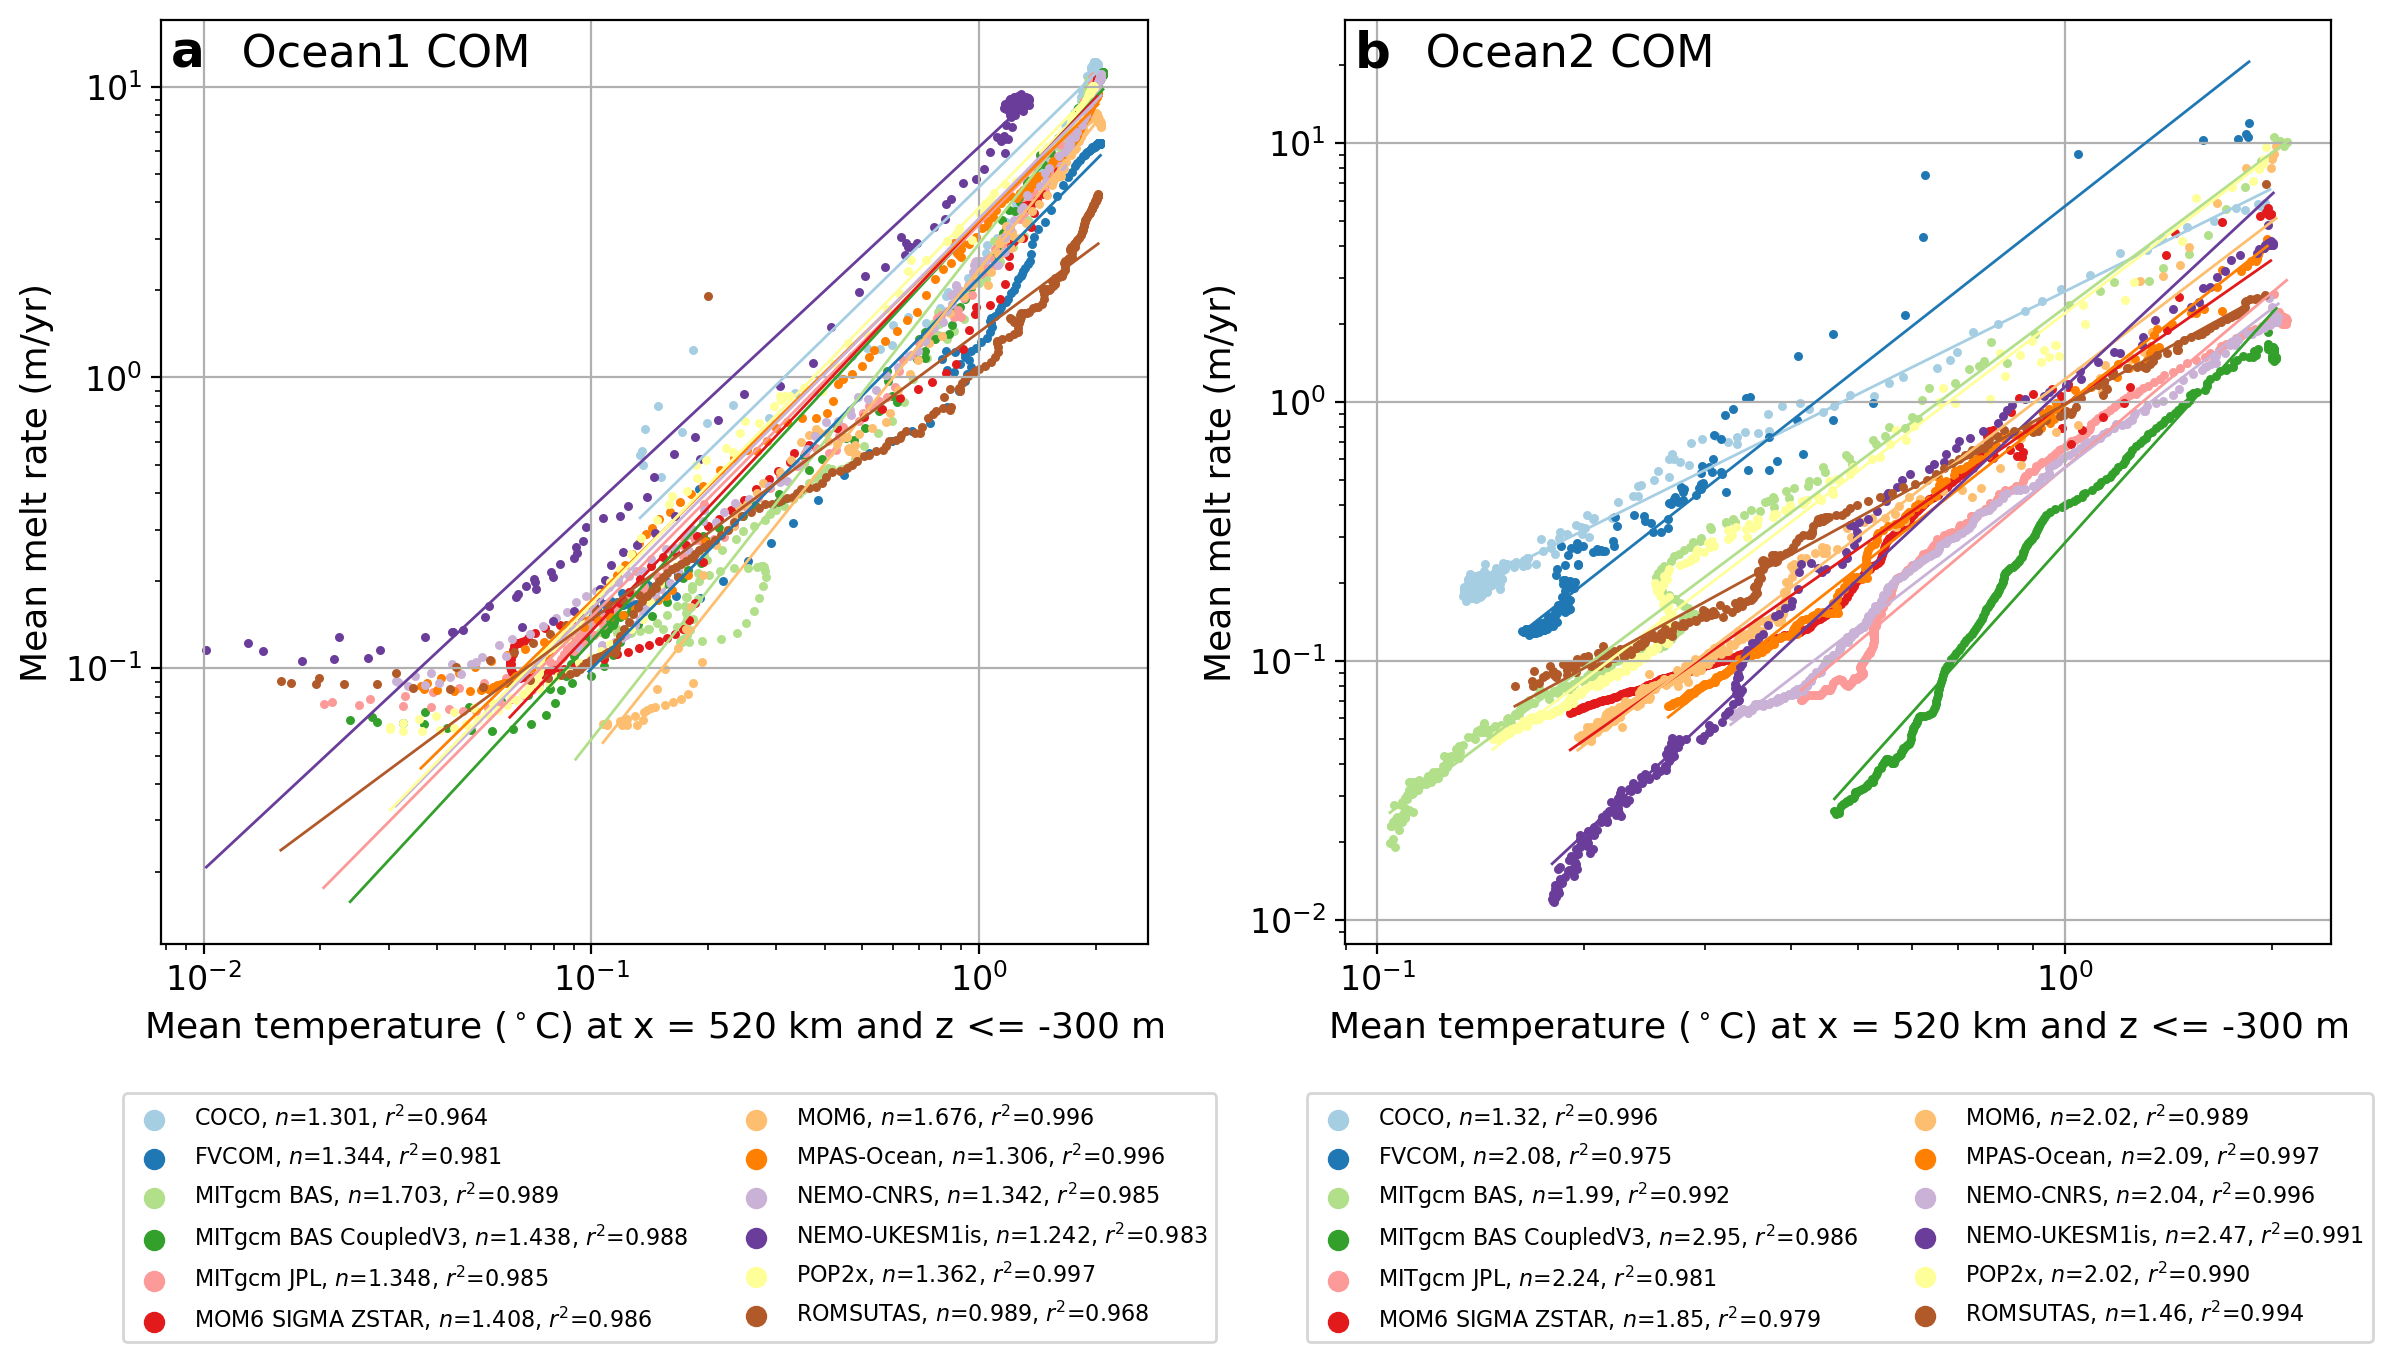

In [64]:
# Linearise the plot with a log-log

z_value = -300

fig = plt.figure(figsize=(14,6),facecolor='w',dpi = 200)

expt = Ocean1_COM
labels = []
for fileIndex in range(len(expt)):
    fileName = expt[fileIndex]
    baseName = os.path.basename(basedrive +fileName)
    modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
    labels.append(modelName)

length = len(expt)
ax = plt.subplot(1,2,1)
for i in np.arange(length):
    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    # set coords
    data = data.set_coords("x")
    data = data.set_coords("y")
    data = data.set_coords("z")
    # get indices for z<= z_value m
    k_indices = np.where(data.z <= z_value)[0]
    
    mr = data.meltRate
    t = data.temperatureYZ
    mr = mr.where(mr < 1e10).mean(['nx','ny'])*sPerYr
    t = t.where(t < 1e10).isel(nz=k_indices).mean(['ny','nz'])
    #print('model = {}, len(t) = {}, len(mr) = {}'.format(labels[i],len(t), len(mr)))
    #ind = np.argsort(t.values)
    #t = t.values[ind]
    #mr = mr.values[ind]
    slope, intercept = np.polyfit(np.log10((t+2.1)), np.log10(mr), 1)
    correlation_coefficient = np.corrcoef(np.log10((t+2.1)), np.log10(mr))[0, 1]
    t2s = np.linspace(min((t+2.1)),max((t+2.1)))
    #log10y = log10x
    ys = t2s**slope *10**intercept
    # y, fnc, r2,p = best_fit(t,mr)   
    # if fnc == "quadratic":
    #     xs = np.linspace(min(t),max(t),100)
    #     ys = p[0]*xs**2+p[1]*xs+p[2]
    # elif fnc == "linear":
    #     xs = np.linspace(min(t),max(t),100)
    #     ys = p[0]*xs+p[1]
    label = labels[i] +', '+ str(r'$n$={:.3f}, $r^2$={:.3f}'.format(slope,correlation_coefficient))
    plt.scatter((t--2.1),mr,label = label, s = mark_size, color=modelcolours[i])
    plt.plot(t2s,ys,'-', color=modelcolours[i], lw=1.)
    #plt.plot((xs-min(t))**2,ys,'-', color=modelcolours[i], lw=1.)

plt.xlabel('Mean temperature ($^\circ$C) at x = 520 km and z <= {} m'.format(z_value), fontsize=fs)
plt.ylabel('Mean melt rate (m/yr)', fontsize=fs)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.tick_params(labelsize=12)


plt.gca().legend(ncol=2, loc='upper left', bbox_to_anchor=(-0.05, -0.15), fontsize=8, markerscale = 3)

plt.text(0.01,0.99,'a', fontsize = 18, transform=ax.transAxes, fontweight='bold', va='top')
plt.text(0.01,0.985,'     Ocean1 COM', fontsize = 16, transform=ax.transAxes, va='top')


expt = Ocean2_COM
labels = []
for fileIndex in range(len(expt)):
    fileName = expt[fileIndex]
    baseName = os.path.basename(basedrive +fileName)
    modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
    labels.append(modelName)

length = len(expt)
ax = plt.subplot(1,2,2)
for i in np.arange(length):
    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    # set coords
    data = data.set_coords("x")
    data = data.set_coords("y")
    data = data.set_coords("z")
    # get indices for z<= z_value m
    k_indices = np.where(data.z <= z_value)[0]
    
    mr = data.meltRate
    t = data.temperatureYZ
    mr = mr.where(mr < 1e10).mean(['nx','ny'])*sPerYr
    t = t.where(t < 1e10).isel(nz=k_indices).mean(['ny','nz'])
    slope, intercept = np.polyfit(np.log10((t+2.1)), np.log10(mr), 1)
    correlation_coefficient = np.corrcoef(np.log10((t+2.1)), np.log10(mr))[0, 1]
    t2s = np.linspace(min((t+2.1)),max((t+2.1)))
    ys = t2s**slope *10**intercept
    label = labels[i] +', '+ str(r'$n$={:.2f}, $r^2$={:.3f}'.format(slope,correlation_coefficient))
    plt.scatter((t--2.1),mr,label = label, s = mark_size, color=modelcolours[i])
    plt.plot(t2s,ys,'-', color=modelcolours[i], lw=1.)
    #plt.plot((xs-min(t))**2,ys,'-', color=modelcolours[i], lw=1.)

plt.xlabel('Mean temperature ($^\circ$C) at x = 520 km and z <= {} m'.format(z_value), fontsize=fs)
plt.ylabel('Mean melt rate (m/yr)', fontsize=fs)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.tick_params(labelsize=12)


plt.gca().legend(ncol=2, loc='upper left', bbox_to_anchor=(-0.05, -0.15), fontsize=8, markerscale = 3)

plt.text(0.01,0.99,'b', fontsize = 18, transform=ax.transAxes, fontweight='bold', va='top')
plt.text(0.01,0.985,'     Ocean2 COM', fontsize = 16, transform=ax.transAxes, va='top')


### Melt vs. salinityYZ

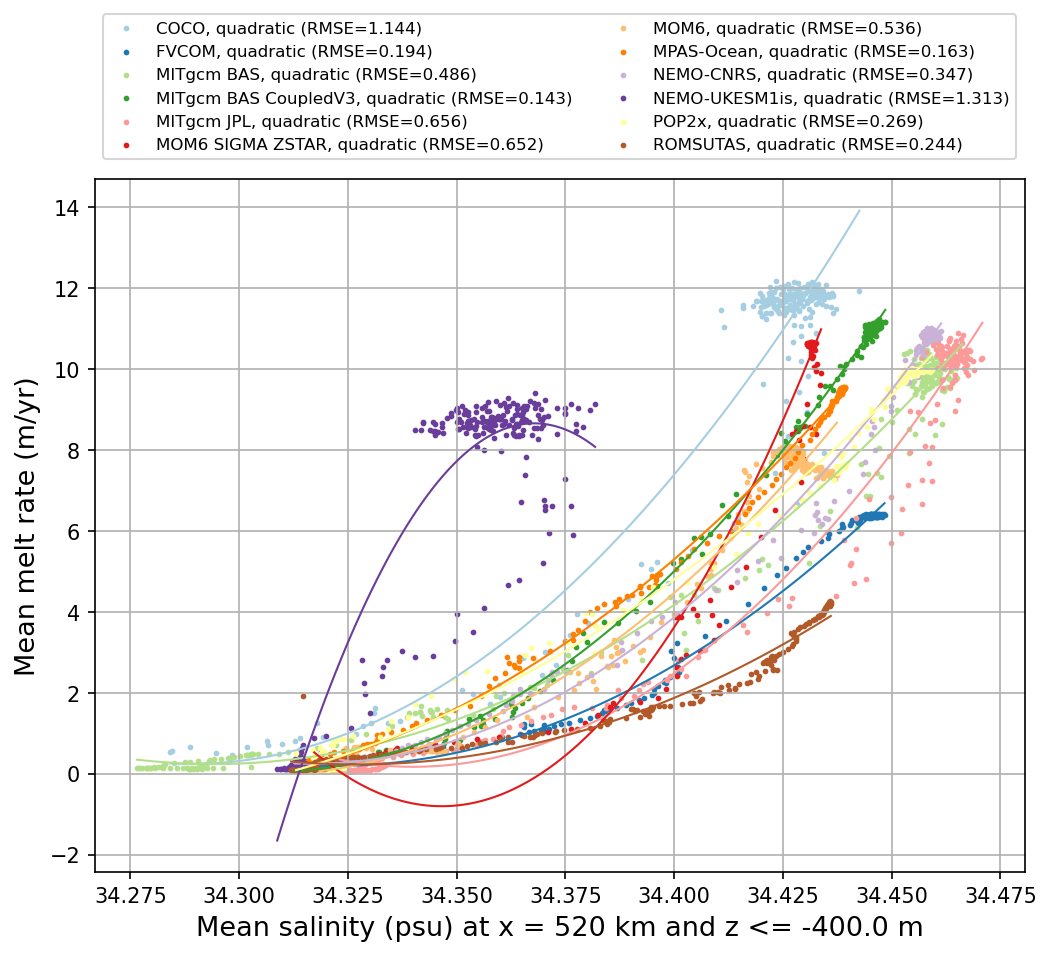

In [83]:
expt = Ocean1_COM
labels = []
for fileIndex in range(len(expt)):
    fileName = expt[fileIndex]
    baseName = os.path.basename(basedrive +fileName)
    modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
    labels.append(modelName)

length = len(expt)
fig = plt.figure(figsize=(8,6),facecolor='w',dpi = 150)

for i in np.arange(length):
    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    # set coords
    data = data.set_coords("x")
    data = data.set_coords("y")
    data = data.set_coords("z")
    # get indices for z<= z_value
    k_indices = np.where(data.z <= z_value)[0]
    
    mr = data.meltRate
    s = data.salinityYZ
    mr = mr.where(mr < 1e10).mean(['nx','ny'])*sPerYr
    s = s.where(s < 1e10).isel(nz=k_indices).mean(['ny','nz'])
    #print('model = {}, len(t) = {}, len(mr) = {}'.format(labels[i],len(t), len(mr)))
    ind = np.argsort(s.values)
    s = s.values[ind]
    mr = mr.values[ind]
    y, fnc, r2,p = best_fit(s,mr)
    if fnc == "quadratic":
        xs = np.linspace(min(s),max(s),100)
        ys = p[0]*xs**2+p[1]*xs+p[2]
    elif fnc == "linear":
        xs = np.linspace(min(s),max(s),100)
        ys = p[0]*xs+p[1]
    label = labels[i] + str(r', {} (RMSE={:.3f})'.format(fnc,r2))
    plt.scatter(s,mr,label = label, s = mark_size, color=modelcolours[i])
    plt.plot(xs,ys,'-', color=modelcolours[i], lw=1.)

plt.xlabel('Mean salinity (psu) at x = 520 km and z <= {} m'.format(z_value), fontsize=fs)
plt.ylabel('Mean melt rate (m/yr)', fontsize=fs)
plt.gca().legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.25), fontsize=8)
plt.grid()
if savefig:
    plt.savefig('melt_vs_salt_x520.png', dpi=300, bbox_inches='tight')

### Melt vs. temperatureXZ

/jobfs/119924872.gadi-pbs/ipykernel_1730145/634517262.py:24: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_linear, _ = curve_fit(linear_func, t, m)
/jobfs/119924872.gadi-pbs/ipykernel_1730145/634517262.py:26: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_quadratic, _ = curve_fit(quadratic_func, t, m)
/jobfs/119924872.gadi-pbs/ipykernel_1730145/634517262.py:24: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_linear, _ = curve_fit(linear_func, t, m)
/jobfs/119924872.gadi-pbs/ipykernel_1730145/634517262.py:26: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_quadratic, _ = curve_fit(quadratic_func, t, m)
/jobfs/119924872.gadi-pbs/ipykernel_1730145/634517262.py:24: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_linear, _ = curve_fit(linear_func, t, m)
/jobfs/119924872.gadi-pbs/ipykernel_1730145/634517262.py:26: OptimizeWarning: Covariance of the pa

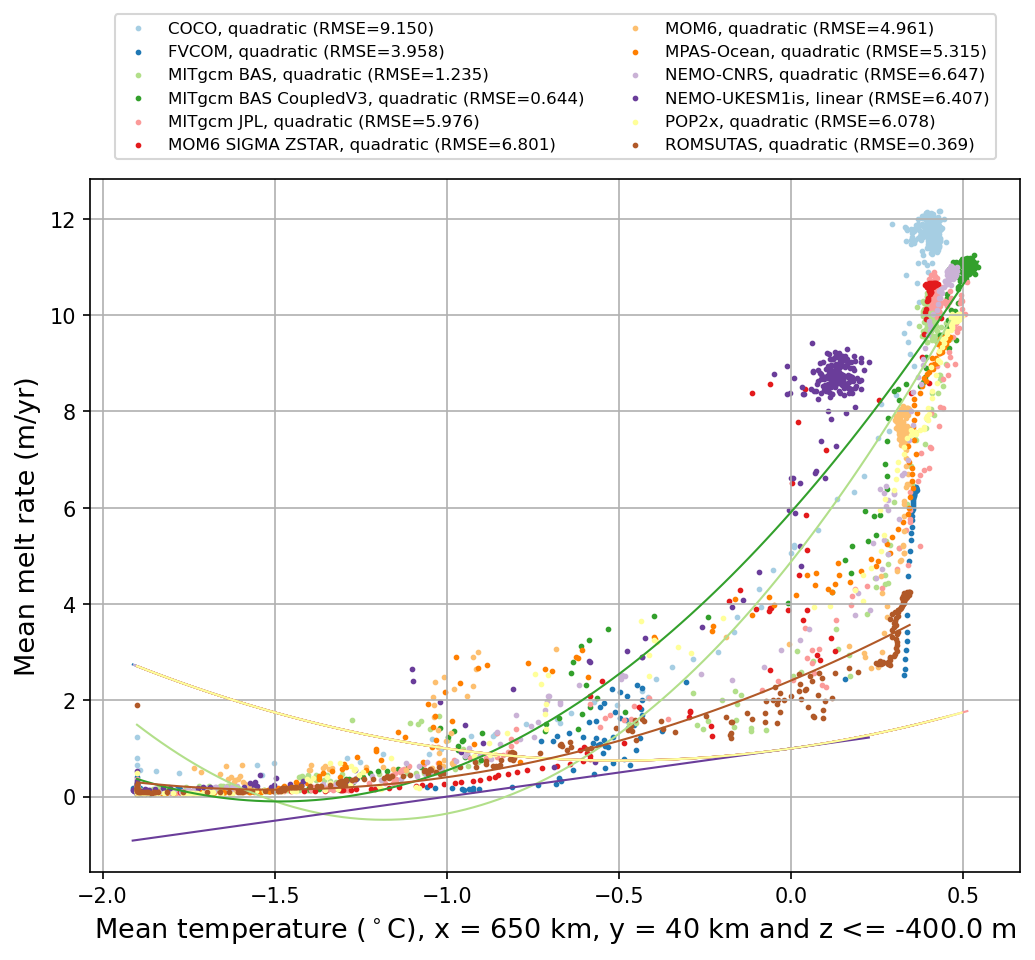

In [86]:
expt = Ocean1_COM
labels = []
for fileIndex in range(len(expt)):
    fileName = expt[fileIndex]
    baseName = os.path.basename(basedrive +fileName)
    modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
    labels.append(modelName)

length = len(expt)
fig = plt.figure(figsize=(8,6),facecolor='w',dpi = 150)

for i in np.arange(length):
    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    # set coords
    data = data.set_coords("x")
    data = data.set_coords("y")
    data = data.set_coords("z")
    # get indices for z<= z_value m
    k_indices = np.where(data.z <= z_value)[0]
    ice_front_index = np.abs(data.x.values - 650.e3).argmin()
    
    mr = data.meltRate
    t = data.temperatureXZ
    mr = mr.where(mr < 1e10).mean(['nx','ny'])*sPerYr
    t = t.where(t < 1e10).isel(nx=ice_front_index).isel(nz=k_indices).mean(['nz'])
    ind = np.argsort(t)
    t = t[ind]
    mr = mr[ind]
    y, fnc, r2,p = best_fit(t,mr)   
    if fnc == "quadratic":
        xs = np.linspace(min(t),max(t),100)
        ys = p[0]*xs**2+p[1]*xs+p[2]
    elif fnc == "linear":
        xs = np.linspace(min(t),max(t),100)
        ys = p[0]*xs+p[1]
    label = labels[i] + str(r', {} (RMSE={:.3f})'.format(fnc,r2))
    plt.scatter(t,mr,label = label, s = mark_size, color=modelcolours[i])
    #plt.plot(t,y,'-', color=modelcolours[i], lw=1.)
    plt.plot(xs,ys,'-', color=modelcolours[i], lw=1.)

plt.xlabel('Mean temperature ($^\circ$C), x = 650 km, y = 40 km and z <= {} m'.format(z_value), fontsize=fs)
plt.ylabel('Mean melt rate (m/yr)', fontsize=fs)
plt.gca().legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.25), fontsize=8)
plt.grid()
if savefig:
    plt.savefig('melt_vs_temp_x650_y40.png', dpi=300, bbox_inches='tight')

### Melt vs. salinityXZ

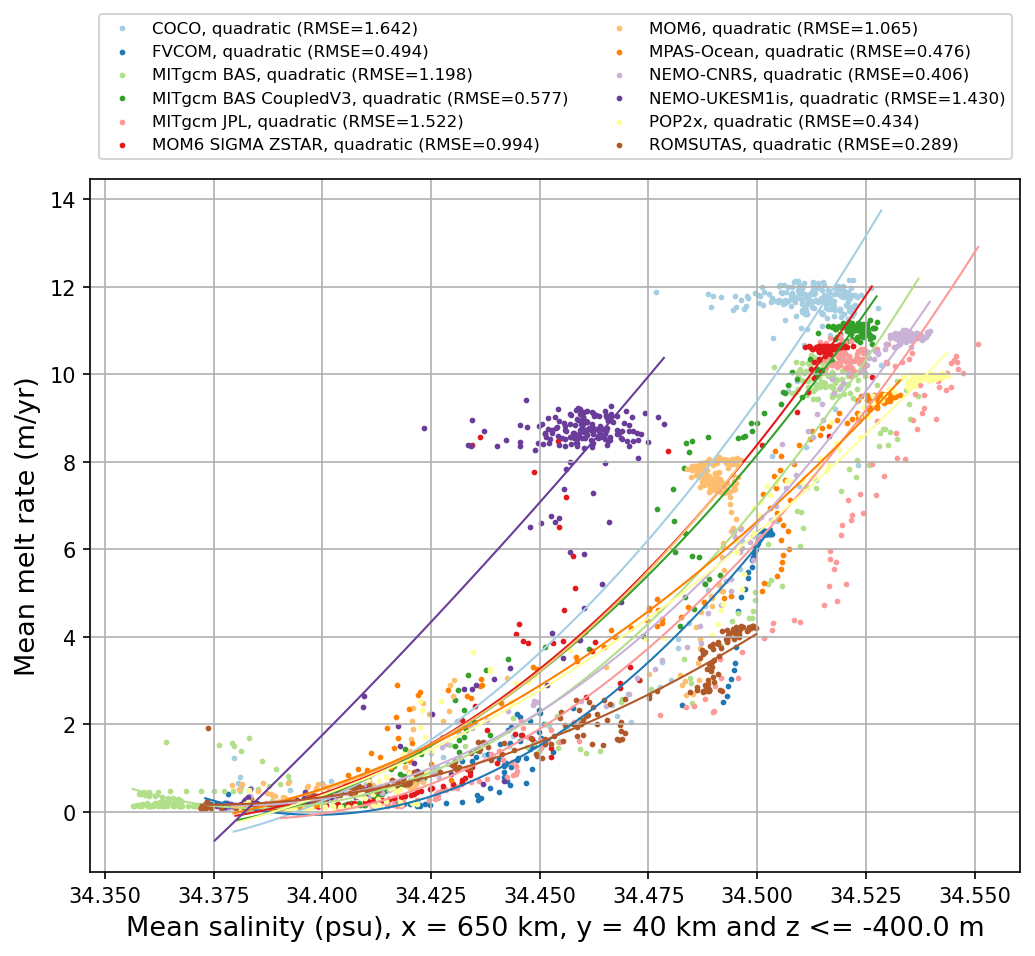

In [85]:
expt = Ocean1_COM
labels = []
for fileIndex in range(len(expt)):
    fileName = expt[fileIndex]
    baseName = os.path.basename(basedrive +fileName)
    modelName = ' '.join(baseName.split('_')[2:]).split('.')[0]
    labels.append(modelName)

length = len(expt)
fig = plt.figure(figsize=(8,6),facecolor='w',dpi = 150)

for i in np.arange(length):
    data = xr.open_dataset(basedrive+expt[i], decode_times=False)
    # set coords
    data = data.set_coords("x")
    data = data.set_coords("y")
    data = data.set_coords("z")
    # get indices for z<= z_value m
    k_indices = np.where(data.z <= z_value)[0]
    ice_front_index = np.abs(data.x.values - 650.e3).argmin()
    
    mr = data.meltRate
    s = data.salinityXZ
    mr = mr.where(mr < 1e10).mean(['nx','ny']).values*sPerYr
    s = s.where(s < 1e10).isel(nx=ice_front_index).isel(nz=k_indices).mean(['nz']).values
    ind = np.argsort(s)
    s = s[ind]
    mr = mr[ind]
    y, fnc, r2,p = best_fit(s,mr)
    if fnc == "quadratic":
        xs = np.linspace(min(s),max(s),100)
        ys = p[0]*xs**2+p[1]*xs+p[2]
    elif fnc == "linear":
        xs = np.linspace(min(s),max(s),100)
        ys = p[0]*xs+p[1]
    label = labels[i] + str(r', {} (RMSE={:.3f})'.format(fnc,r2))
    plt.scatter(s,mr,label = label, s = mark_size, color=modelcolours[i])
    plt.plot(xs,ys,'-', color=modelcolours[i], lw=1.)

plt.xlabel('Mean salinity (psu), x = 650 km, y = 40 km and z <= {} m'.format(z_value), fontsize=fs)
plt.ylabel('Mean melt rate (m/yr)', fontsize=fs)
plt.gca().legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.25), fontsize=8)
plt.grid()
if savefig:
    plt.savefig('melt_vs_salt_x650_y40.png', dpi=300, bbox_inches='tight')